In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, find_events, pick_types, set_eeg_reference
from mne.channels import read_layout
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from mne import viz

%matplotlib inline

In [9]:
# path to data (change this to whereever you saved your data)
myPath = r'F:\TFM\data\seizures_Khan_0\recordings'

# This will determine the time window for the data that we care about
tmin, tmax = -0.1, 1.

In [3]:
# single subject
data = os.listdir(myPath)
dataPath = os.path.join(myPath, data[0])

# We use mne.read_raw_edf to read in the .bdf EEG files
raw = read_raw_edf(dataPath, preload=True, stim_channel='auto', verbose=False)
raw

<ipython-input-3-ee4336b0b54b>:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = read_raw_edf(dataPath, preload=True, stim_channel='auto', verbose=False)


<RawEDF | chb01_03.edf, 23 x 921600 (3600.0 s), ~161.7 MB, data loaded>

In [4]:
# what does our data look like?

print('Data type: {}\n\n{}\n'.format(type(raw), raw))
# print('{} \n'.format(raw))

# Get the sample rate
print('Sample rate:', raw.info['sfreq'], 'Hz')

# Get the size of the matrix
print('Size of the matrix: {}\n'.format(raw.get_data().shape))

# We can use the mne.info class to learn moure about the data.
print(raw.info)

Data type: <class 'mne.io.edf.edf.RawEDF'>

<RawEDF | chb01_03.edf, 23 x 921600 (3600.0 s), ~161.7 MB, data loaded>

Sample rate: 256.0 Hz
Size of the matrix: (23, 921600)

<Info | 7 non-empty values
 bads: []
 ch_names: FP1-F7, F7-T7, T7-P7, P7-O1, FP1-F3, F3-C3, C3-P3, P3-O1, ...
 chs: 23 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2076-11-06 13:43:04 UTC
 nchan: 23
 projs: []
 sfreq: 256.0 Hz
>


In [5]:
print('The actual data is just a matrix array!\n\n {}\n'.format(raw.get_data()))

The actual data is just a matrix array!

 [[-1.77777778e-05  1.95360195e-07  1.95360195e-07 ... -1.77777778e-05
  -8.79120879e-06 -4.88400488e-06]
 [ 3.92673993e-05  1.95360195e-07  1.95360195e-07 ... -2.32478632e-05
  -2.24664225e-05 -2.05128205e-05]
 [-3.71184371e-06  1.95360195e-07  1.95360195e-07 ...  5.91941392e-05
   6.03663004e-05  5.91941392e-05]
 ...
 [-9.18192918e-06  1.95360195e-07  1.95360195e-07 ...  4.86446886e-05
   2.79365079e-05  1.26984127e-05]
 [-3.96581197e-05  1.95360195e-07  1.95360195e-07 ...  4.35653236e-05
   3.84859585e-05  3.61416361e-05]
 [-5.99755800e-05  1.95360195e-07  1.95360195e-07 ...  1.93406593e-05
   2.63736264e-05  3.22344322e-05]]



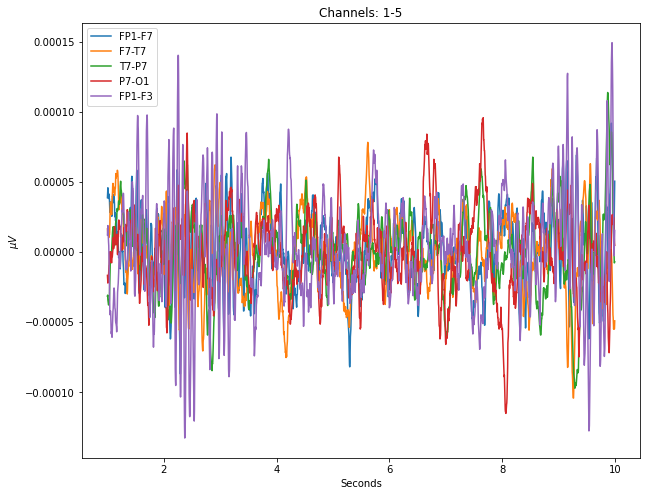

In [6]:
# Extract data from the first 5 channels, and first 10 seconds.
sfreq = raw.info['sfreq']
sfreq = raw.info['sfreq']
data, times = raw[:5, int(sfreq * 1):int(sfreq * 10)]

fig = plt.subplots(figsize=(10,8))
plt.plot(times, data.T);
plt.xlabel('Seconds')
plt.ylabel('$\mu V$')
plt.title('Channels: 1-5');
plt.legend(raw.ch_names[:5]);

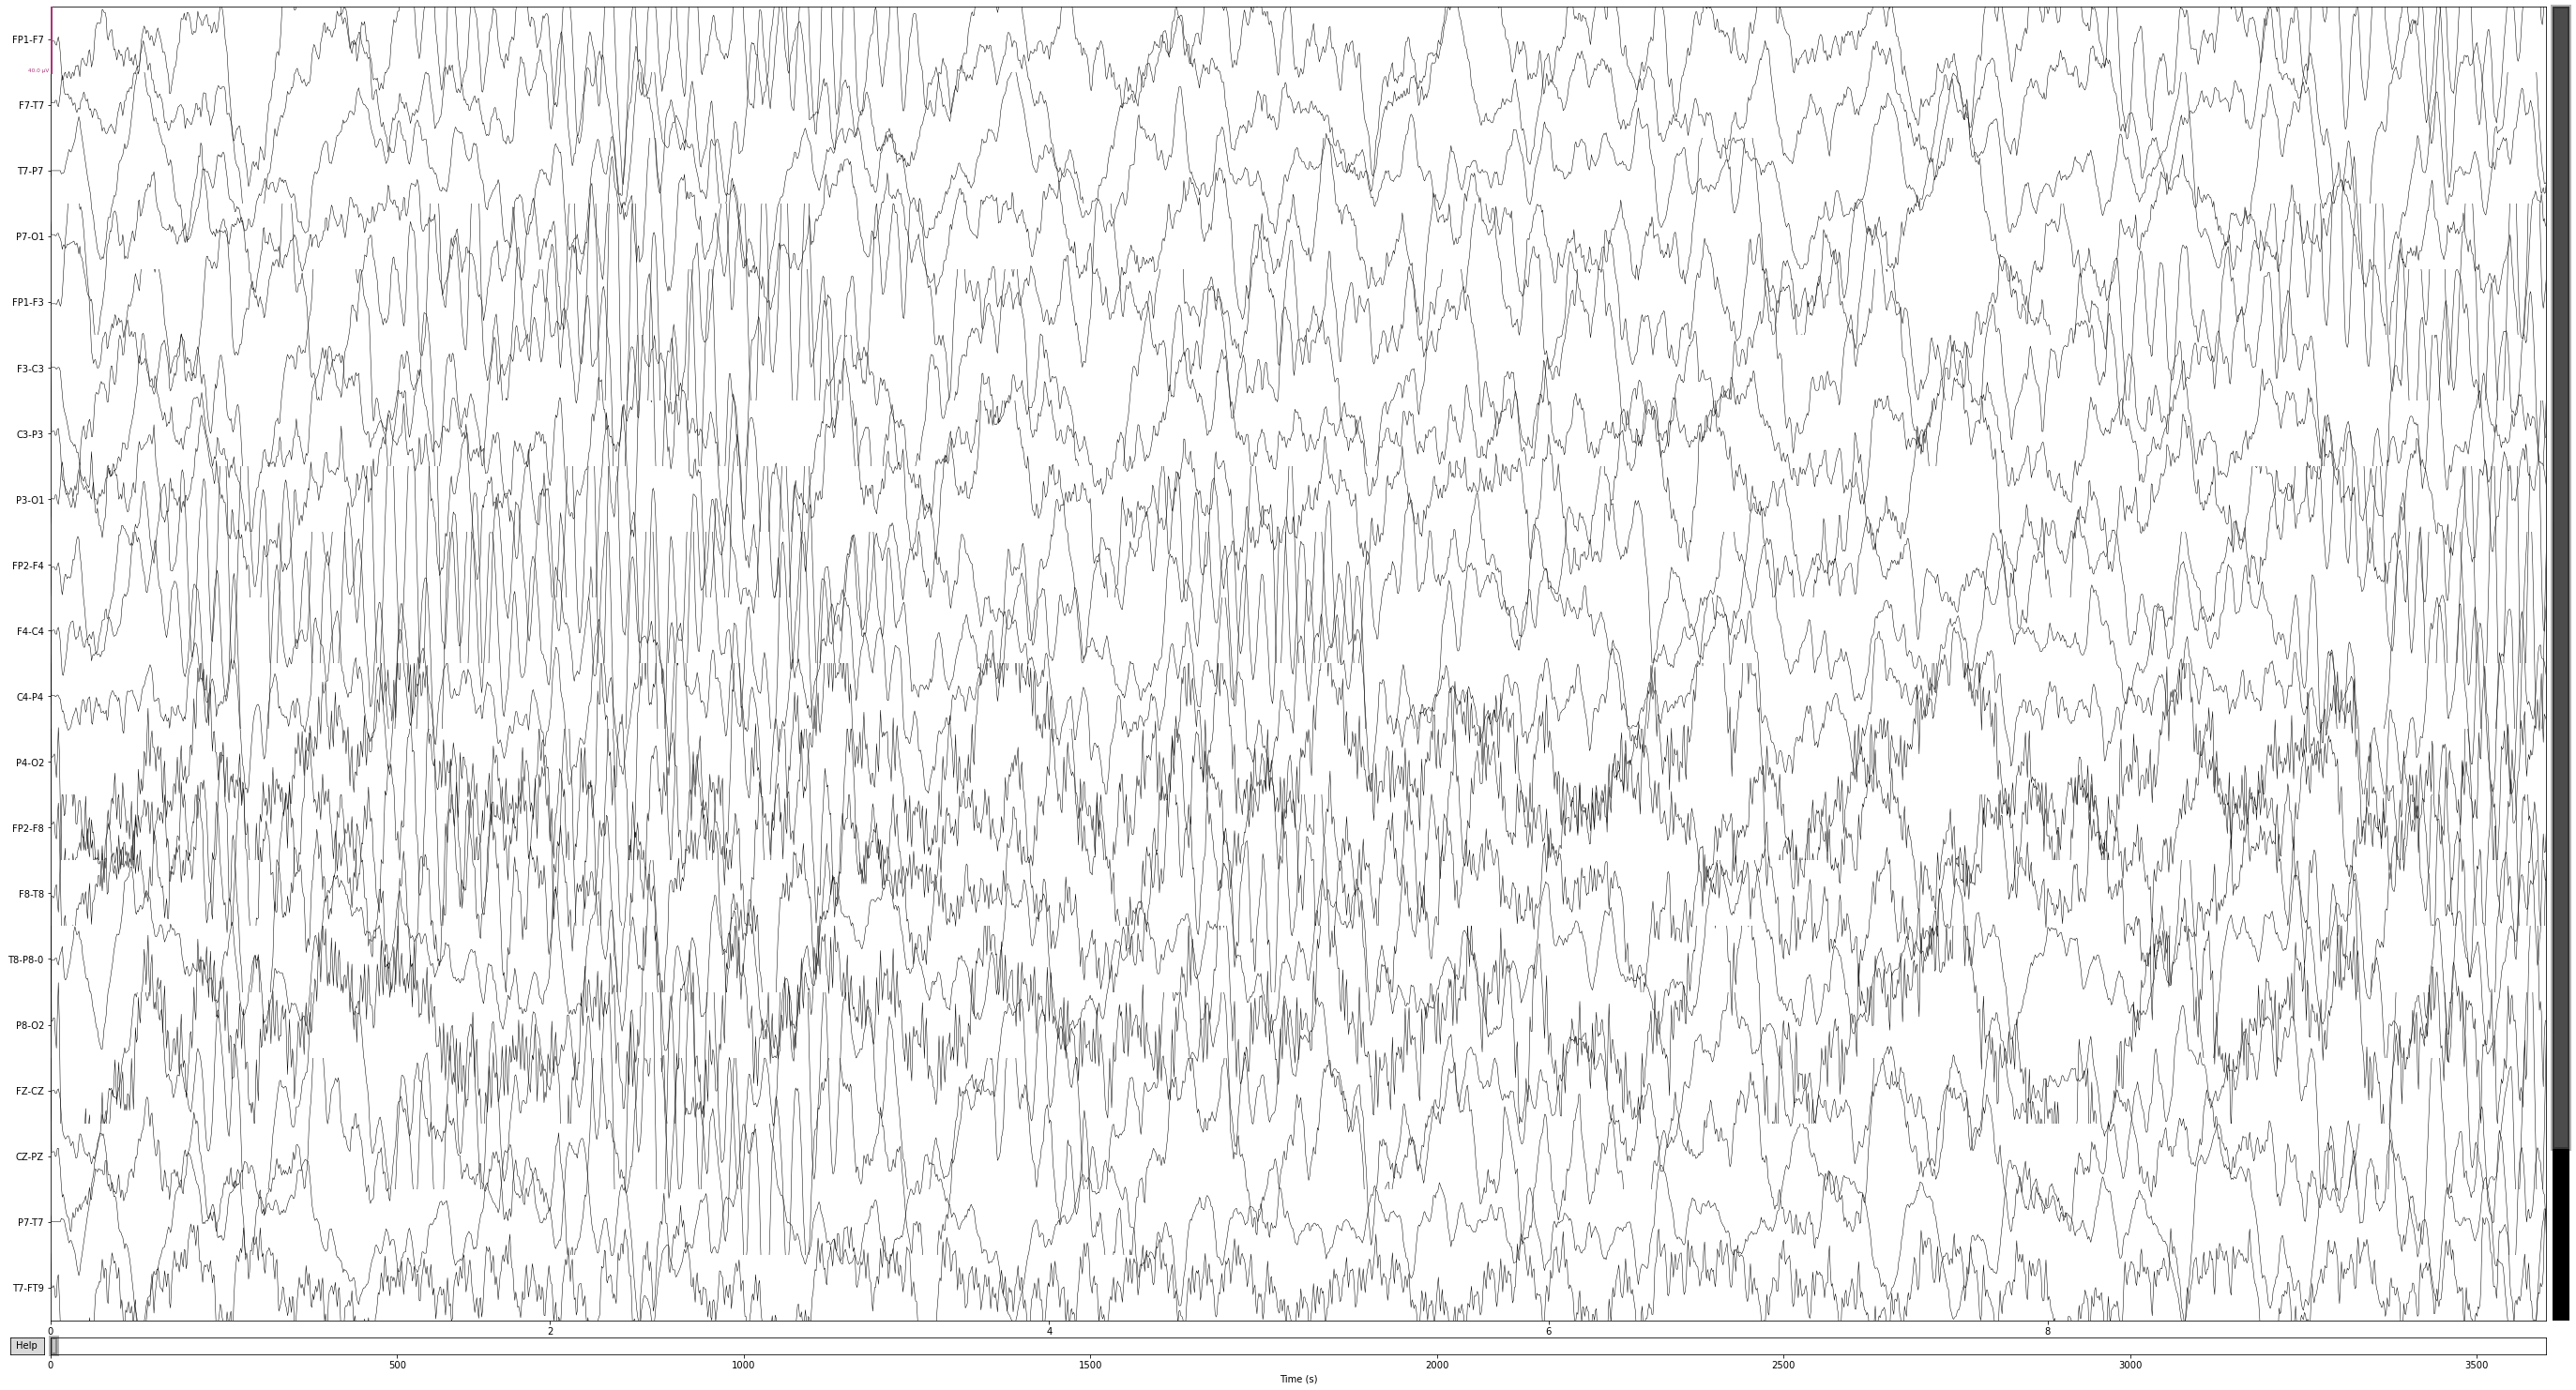

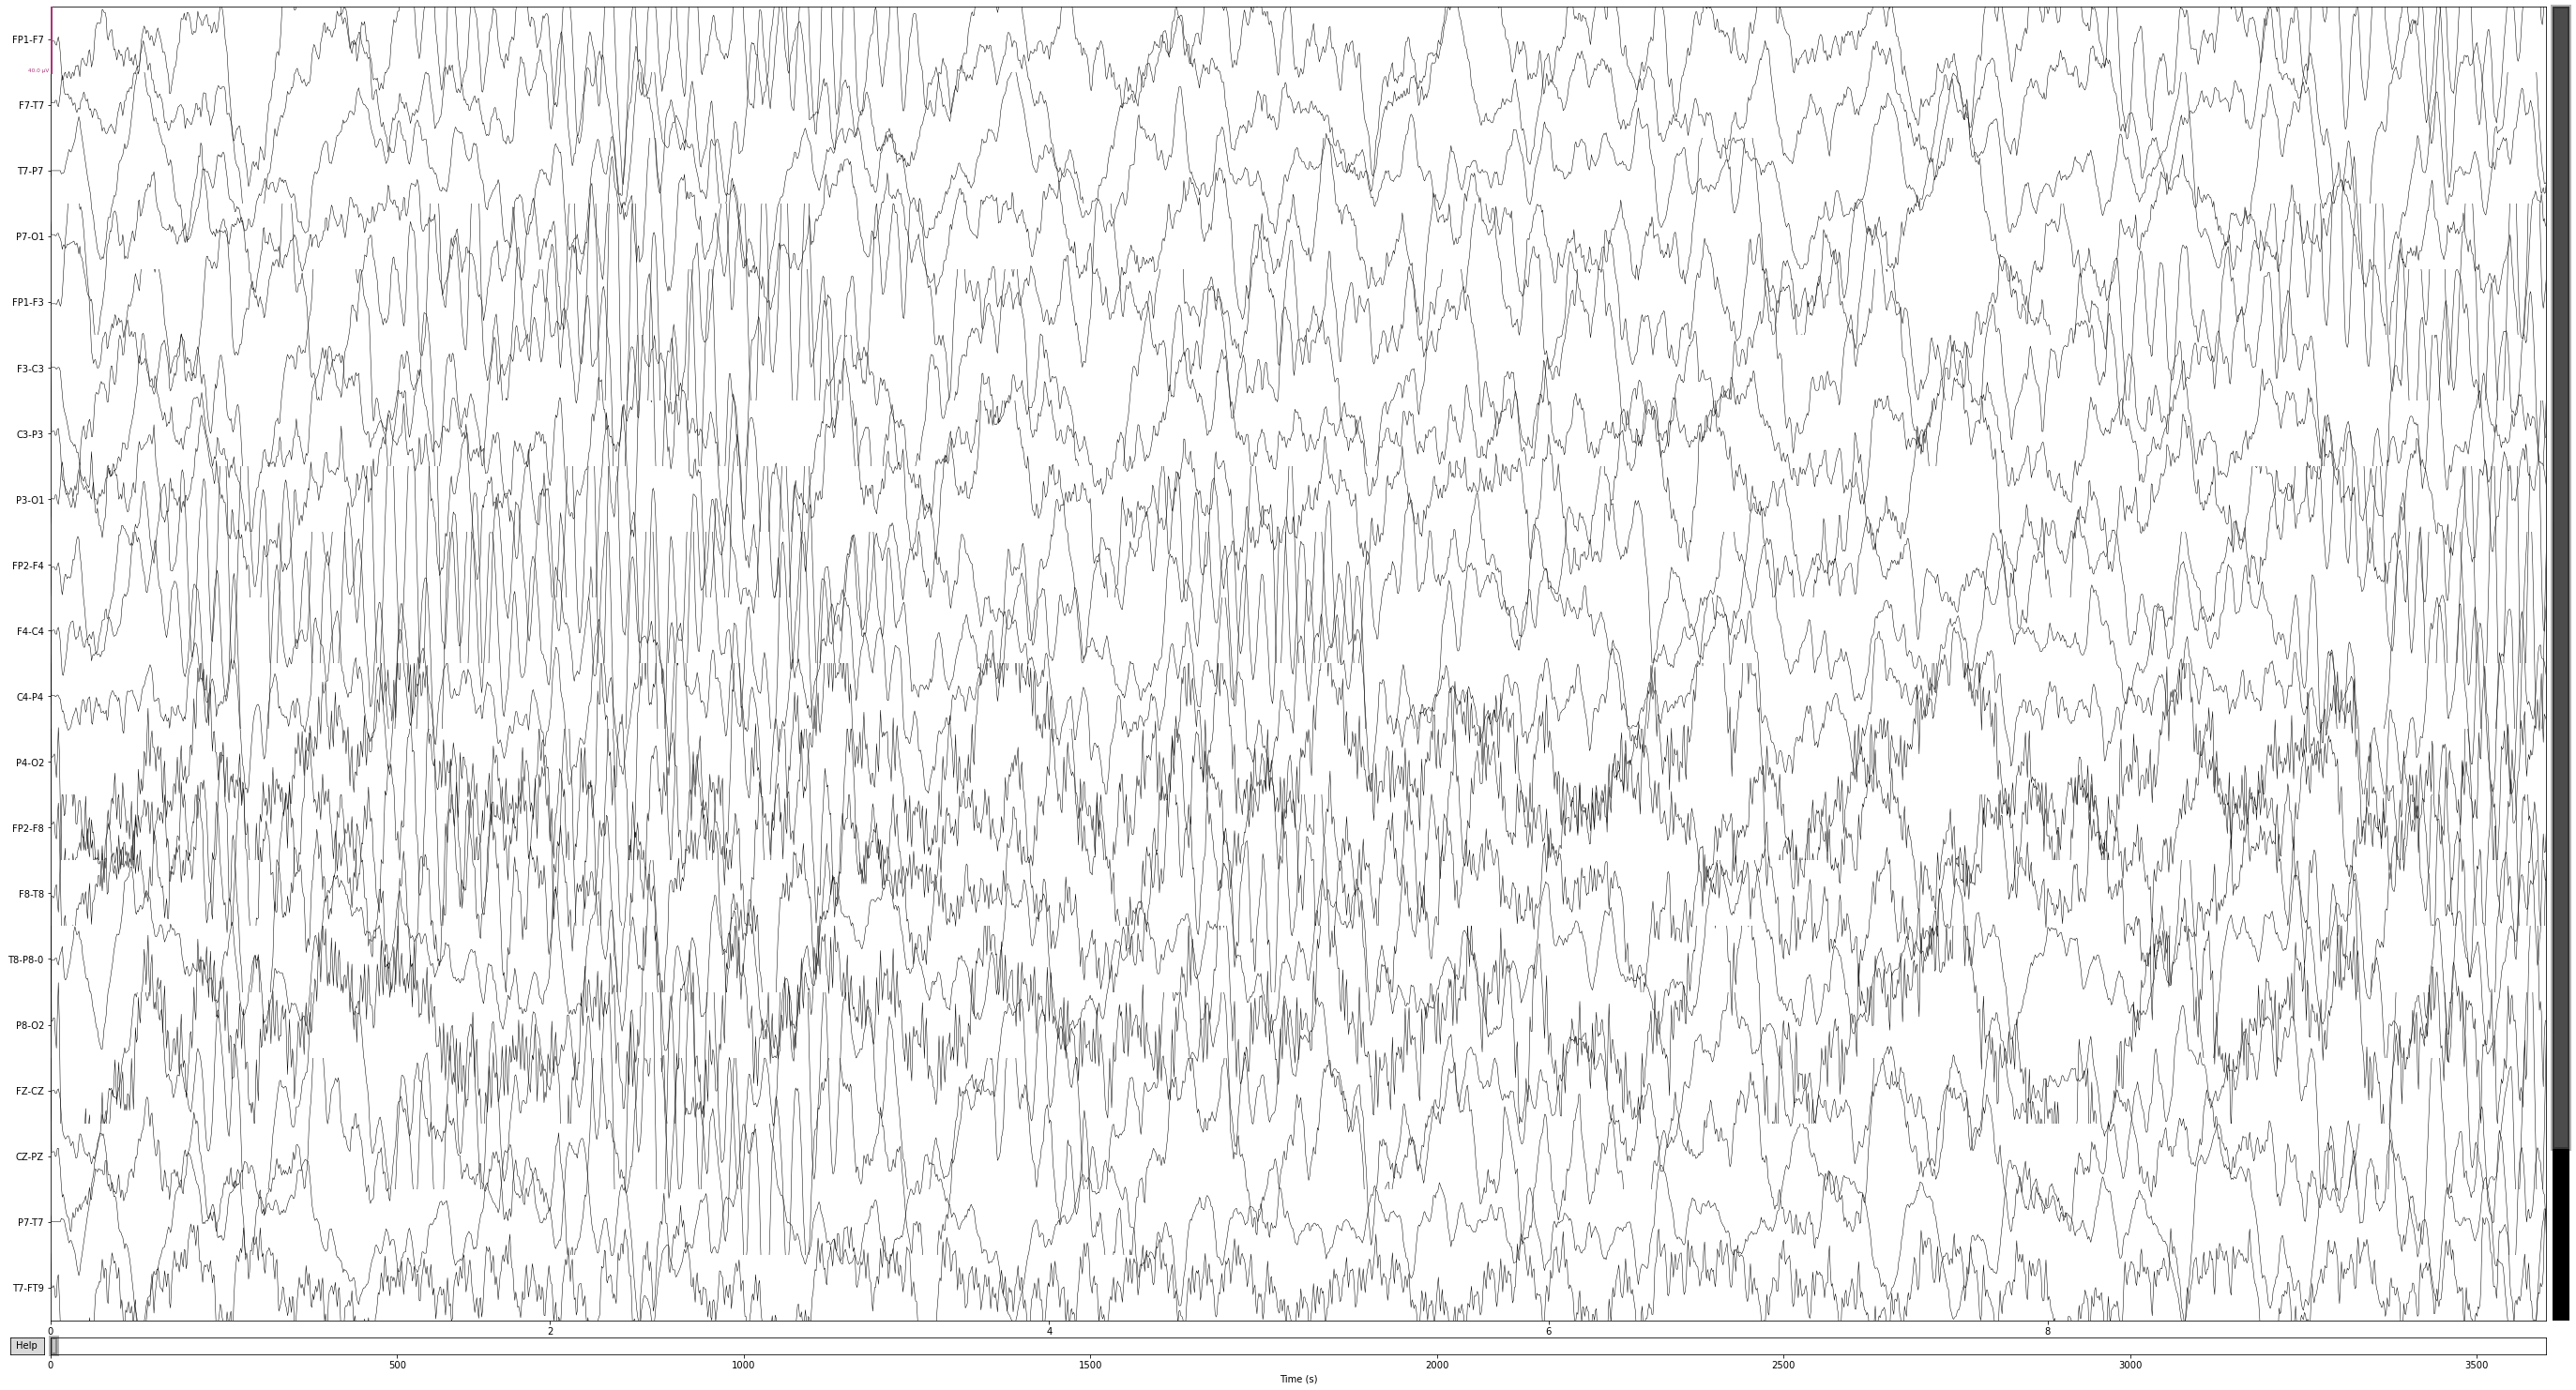

In [8]:
# %matplotlib qt
raw.plot(duration=10, block=True)

<ipython-input-11-840c07dbf628>:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(tmax=np.inf, fmax=128)


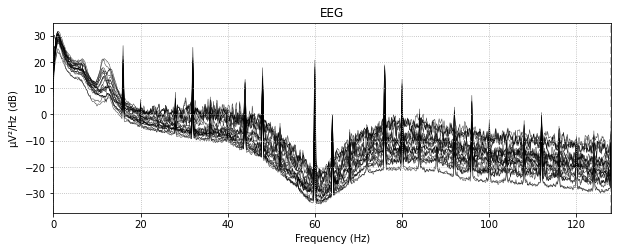

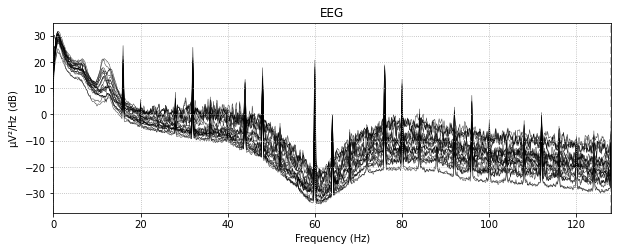

In [11]:
# %matplotlib qt
raw.plot_psd(tmax=np.inf, fmax=128)

In [15]:
raw_df = raw.to_data_frame()
raw_df.head()

time     FP1-F7      F7-T7     T7-P7     P7-O1    FP1-F3     F3-C3  \
0     0 -17.777778  39.267399 -3.711844  8.400488 -0.586081  4.102564   
1     4   0.195360   0.195360  0.195360  0.195360  0.195360  0.195360   
2     8   0.195360   0.195360  0.195360  0.195360  0.195360  0.195360   
3    12   0.586081   0.195360  0.195360  0.195360  0.195360  0.195360   
4    16   0.195360   0.195360  0.195360  0.195360  0.195360  0.195360   

       C3-P3      P3-O1     FP2-F4  ...       F8-T8   T8-P8-0       P8-O2  \
0  37.704518 -15.042735 -17.387057  ... -106.862027 -59.97558  180.317460   
1   0.195360   0.195360   0.195360  ...    0.195360   0.19536    0.195360   
2   0.195360   0.195360   0.195360  ...    0.195360   0.19536    0.195360   
3   0.586081  -0.195360   0.195360  ...   -0.976801   0.19536    2.148962   
4   0.195360   0.195360   0.195360  ...    0.195360   0.19536    2.148962   

       FZ-CZ      CZ-PZ     P7-T7     T7-FT9  FT9-FT10   FT10-T8   T8-P8-1  
0 -18.559219  85.372405  4.102564  20.903541 -9.181929 -39.65812 -59.97558  
1   0.195360   0.195360  0.195360   0.195360  0.195360   0.19536   0.19536  
2   0.195360   0.195360  0.195360   0.195360  0.195360   0.19536   0.19536  
3   0.586081   0.586081  0.195360   1.367521 -0.195360  -0.19536   0.19536  
4   0.195360   0.195360  0.195360  -0.195360  0.195360   0.19536   0.19536  

[5 rows x 24 columns]

In [20]:
raw_df.shape

(921600, 24)